# So sánh dự báo LTSF với FPT_hidden-test

Notebook này tải toàn bộ file dự báo trong thư mục `submissions`, đối chiếu với dữ liệu thực tế `FPT_hidden-test.csv`, tính toán các chỉ số RMSE/MAE/MSE/R² và trực quan hóa top mô hình.

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')

In [21]:
hidden_df = pd.read_csv('./data/FPT_hidden-test.csv')
hidden_df['time'] = pd.to_datetime(hidden_df['time'])
hidden_df = hidden_df.sort_values('time').reset_index(drop=True)
hidden_close = hidden_df['close'].astype(float).values
print(f"FPT_hidden-test length: {len(hidden_df)} rows from {hidden_df['time'].min().date()} to {hidden_df['time'].max().date()}")
display(hidden_df.head())

FPT_hidden-test length: 100 rows from 2025-03-11 to 2025-08-01


,time,open,high,low,close,volume,symbol
0,2025-03-11,118.98,119.42,118.12,118.55,5801595,FPT
1,2025-03-12,118.73,119.59,117.17,117.17,6229823,FPT
2,2025-03-13,117.35,118.98,117.35,117.69,3630282,FPT
3,2025-03-14,116.92,117.52,112.78,113.29,16174178,FPT
4,2025-03-17,113.47,113.90,111.74,112.09,6750806,FPT


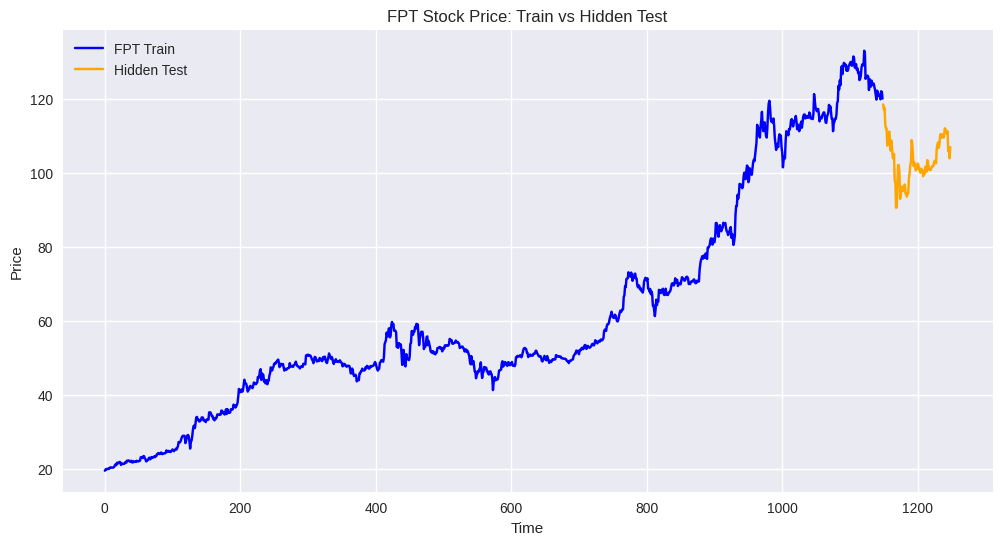

In [22]:
fpt_train = pd.read_csv('./data/FPT_train.csv')

# Plotting
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(fpt_train.index, fpt_train['close'], label='FPT Train', color='blue')

# Plot the hidden data, shifting the index to continue from where train left off
# Assuming hidden_df is already defined in the environment
start_index = fpt_train.index[-1] + 1
new_index = range(start_index, start_index + len(hidden_df))
plt.plot(new_index, hidden_df['close'], label='Hidden Test', color='orange')

plt.title('FPT Stock Price: Train vs Hidden Test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [23]:
submissions_dir = './submissions/default'
forecast_files = sorted([f for f in os.listdir(submissions_dir) if f.startswith('Sub_') and f.endswith('.csv')])
if not forecast_files:
    raise FileNotFoundError('Không tìm thấy file dự báo trong thư mục submissions.')

records = []
max_len = len(hidden_close)
for filename in forecast_files:
    file_path = os.path.join(submissions_dir, filename)
    forecast_df = pd.read_csv(file_path)
    preds = forecast_df['close'].astype(float).values
    aligned_len = min(len(preds), max_len)
    preds_clip = preds[:aligned_len]
    actual_clip = hidden_close[:aligned_len]
    mse = mean_squared_error(actual_clip, preds_clip)
    mae = mean_absolute_error(actual_clip, preds_clip)
    rmse = np.sqrt(mse)
    try:
        r2 = r2_score(actual_clip, preds_clip)
    except ValueError:
        r2 = np.nan
    slug = filename.replace('Sub_', '').replace('.csv', '')
    model_name = slug
    records.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'ForecastFile' : file_path
    })

comparison_df = pd.DataFrame(records).sort_values('RMSE').reset_index(drop=True)
print('Bảng so sánh theo RMSE tăng dần:')
display(comparison_df)

Bảng so sánh theo RMSE tăng dần:


,Model,RMSE,MAE,MSE,ForecastFile
0,Univariate_DLinear_RevIN_NoHMM_Seq480_MSE5073,5.909574,4.879069,34.923064,./submissions/default/Sub_Univariate_DLinear_R...
1,Univariate_Linear_RevIN_NoHMM_Seq480_MSE4888,6.070590,4.989497,36.852067,./submissions/default/Sub_Univariate_Linear_Re...
2,Multivariate_DLinear_RevIN_HMM3W60_Seq60_MSE357,6.939655,5.448840,48.158813,./submissions/default/Sub_Multivariate_DLinear...
3,Multivariate_Linear_RevIN_HMM3W60_Seq60_MSE313,7.102623,5.589385,50.447257,./submissions/default/Sub_Multivariate_Linear_...
4,Multivariate_Linear_RevIN_HMM3W30_Seq60_MSE86,7.228728,5.918406,52.254502,./submissions/default/Sub_Multivariate_Linear_...
...,...,...,...,...,...
215,Univariate_DLinear_NoRevIN_NoHMM_Seq60_MSE144,41.412423,40.193446,1714.988756,./submissions/default/Sub_Univariate_DLinear_N...
216,Multivariate_Linear_NoRevIN_NoHMM_Seq480_MSE2171,41.683451,32.744468,1737.510078,./submissions/default/Sub_Multivariate_Linear_...
217,Univariate_Linear_NoRevIN_HMM3W60_Seq60_MSE113,42.490252,41.143500,1805.421549,./submissions/default/Sub_Univariate_Linear_No...
218,Univariate_Linear_NoRevIN_NoHMM_Seq60_MSE117,43.038080,41.740689,1852.276346,./submissions/default/Sub_Univariate_Linear_No...


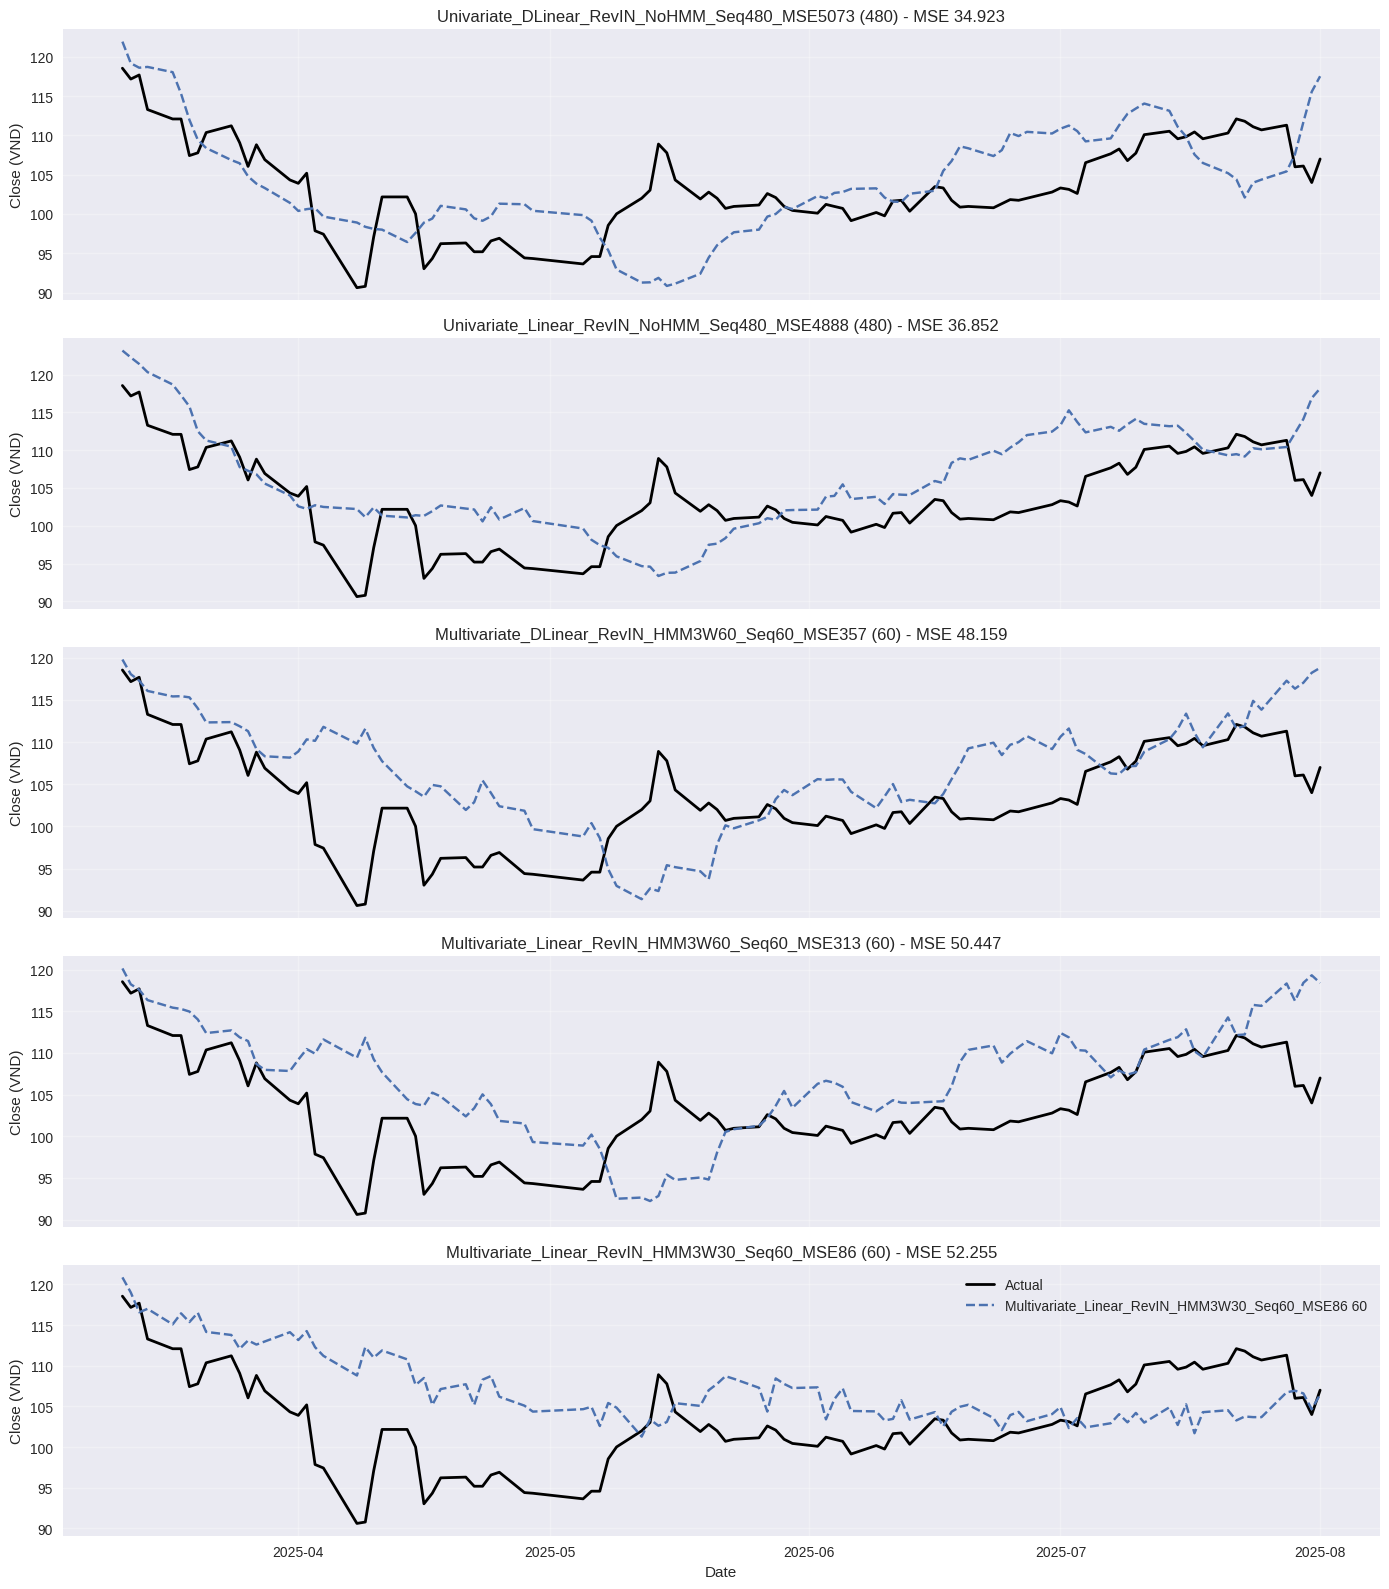

In [24]:
# top_k = min(4, len(comparison_df))
top_k = 5
if top_k == 0:
    print('Không có bản ghi để vẽ.')
else:
    fig, axes = plt.subplots(top_k, 1, figsize=(14, 3.2 * top_k), sharex=True)
    if top_k == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, comparison_df.head(top_k).iterrows()):
        forecast_df = pd.read_csv(row['ForecastFile'])
        preds = forecast_df['close'].astype(float).values
        aligned_len = min(len(preds), len(hidden_close))
        ax.plot(hidden_df['time'][:aligned_len], hidden_close[:aligned_len], label='Actual', color='black', linewidth=2)
        # Fix for missing Horizon key
        horizon = row.get('Horizon')
        if pd.isna(horizon) or horizon is None:
            import re
            match = re.search(r'Seq(\d+)', str(row['Model']))
            horizon = match.group(1) if match else 'Unknown'
        ax.plot(hidden_df['time'][:aligned_len], preds[:aligned_len], label=f"{row['Model']} {horizon}", linestyle='--')
        ax.set_title(f"{row['Model']} ({horizon}) - MSE {row['MSE']:.3f}")
        ax.set_ylabel('Close (VND)')
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel('Date')
    axes[-1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [25]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display

def evaluate_submissions(hidden_close, submissions_dir='./submissions/', default_val_mse=np.nan):
    """
    Hàm quét thư mục submission và so sánh với hidden_close.
    
    Args:
        hidden_close (array-like): Dữ liệu thực tế để so sánh.
        submissions_dir (str): Đường dẫn đến thư mục chứa file csv.
        default_val_mse (float/nan): Giá trị gán cho valMSE nếu không parse được từ tên file.
    
    Returns:
        pd.DataFrame: Bảng kết quả so sánh.
    """
    
    # 1. Lấy danh sách file
    if not os.path.exists(submissions_dir):
        print(f"⚠️ Thư mục không tồn tại: {submissions_dir}")
        return pd.DataFrame()

    forecast_files = sorted([f for f in os.listdir(submissions_dir) 
                             if f.endswith('.csv') and (f.startswith('Ext_') or f.startswith('Sub_'))])

    if not forecast_files:
        print(f"⚠️ Không tìm thấy file .csv nào trong {submissions_dir}")
        return pd.DataFrame()
    else:
        print(f"Đã tìm thấy {len(forecast_files)} file dự báo. Đang tính toán...")

    records = []
    max_len = len(hidden_close) 

    for filename in forecast_files:
        file_path = os.path.join(submissions_dir, filename)
        try:
            forecast_df = pd.read_csv(file_path)
            
            if 'close' not in forecast_df.columns:
                continue
                
            preds = forecast_df['close'].astype(float).values
            
            # Cắt ngắn hoặc giữ nguyên độ dài
            aligned_len = min(len(preds), max_len)
            if aligned_len == 0: continue
                
            preds_clip = preds[:aligned_len]
            actual_clip = hidden_close[:aligned_len]
            
            # Metrics
            mse = mean_squared_error(actual_clip, preds_clip)
            # mae = mean_absolute_error(actual_clip, preds_clip) # (Optional)
                
            # --- LOGIC PARSE TÊN FILE & CUSTOM VAL_MSE ---
            slug = filename.replace('.csv', '')
            
            # Khởi tạo giá trị mặc định để tránh lỗi NameError
            val_mse = default_val_mse
            
            if filename.startswith('Sub_'):
                parts = slug.split('_')
                # Format: Sub_{Model}_{HMM}_{Win}_{Seq}_{MSE}
                # Cần ít nhất 6 phần: Sub, Model(1+), HMM, Win, Seq, MSE
                if len(parts) >= 6:
                    try:
                        mse_tag = parts[-1]   # MSExxx
                        if 'MSE' in mse_tag:
                            val_mse = int(mse_tag.replace('MSE', ''))
                        
                        seq_tag = parts[-2]
                        win_tag = parts[-3]
                        hmm_tag = parts[-4]
                        model_name = "_".join(parts[1:-4])
                        info_str = f"{hmm_tag} | {seq_tag}"
                    except:
                        # Fallback nếu parse lỗi
                        model_name = slug
                        info_str = "Parse Error"
                else:
                    model_name = slug
                    info_str = "Custom Structure"
            else:
                # Legacy files
                clean_name = slug.replace('submission_', '').replace('_100d', '')
                model_name = clean_name
                info_str = "Legacy"

            records.append({
                'Model': model_name,
                'Config': info_str,
                'MSE': mse,
                'valMSE': val_mse, # Giá trị này giờ luôn an toàn
                'Filename': filename
            })
            
        except Exception as e:
            print(f"Lỗi file {filename}: {e}")

    # Tạo bảng và hiển thị
    if records:
        comparison_df = pd.DataFrame(records).sort_values('MSE').reset_index(drop=True)
        
        best_model = comparison_df.iloc[0]
        print(f"\n🏆 TOP 1: {best_model['Model']} | MSE: {best_model['MSE']:.2f}")
        
        # Display style
        display(comparison_df.style.background_gradient(subset=['MSE', 'valMSE'], cmap='RdYlGn_r'))
        return comparison_df
    else:
        print("Chưa có dữ liệu.")
        return pd.DataFrame()

In [26]:
# Thử nghiệm gia tăng cửa sổ pred len trong tập train/val/test
df_result = evaluate_submissions(hidden_close, submissions_dir='./submissions/pred_len_tuning/')

Đã tìm thấy 28 file dự báo. Đang tính toán...

🏆 TOP 1: Univariate_DLinear_RevIN_MSE | MSE: 34.92


,Model,Config,MSE,valMSE,Filename
0,Univariate_DLinear_RevIN_MSE,NoHMM | Pred100,34.923064,5073,Sub_Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_Pred100_MSE5073.csv
1,Univariate_DLinear_RevIN_MSE,NoHMM | Pred120,35.486093,5976,Sub_Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_Pred120_MSE5976.csv
2,Univariate_Linear_RevIN_MSE,NoHMM | Pred100,36.852067,4888,Sub_Univariate_Linear_RevIN_MSE_NoHMM_Seq480_Pred100_MSE4888.csv
3,Multivariate_DLinear_RevIN_MSE,HMM3W30 | Pred200,37.767894,600,Sub_Multivariate_DLinear_RevIN_MSE_HMM3W30_Seq60_Pred200_MSE600.csv
4,Univariate_DLinear_RevIN_MSE,NoHMM | Pred150,39.895641,6792,Sub_Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_Pred150_MSE6792.csv
5,Univariate_Linear_RevIN_MSE,NoHMM | Pred120,40.674773,5777,Sub_Univariate_Linear_RevIN_MSE_NoHMM_Seq480_Pred120_MSE5777.csv
6,Multivariate_Linear_RevIN_MSE,HMM3W30 | Pred200,41.399868,511,Sub_Multivariate_Linear_RevIN_MSE_HMM3W30_Seq60_Pred200_MSE511.csv
7,Multivariate_Linear_RevIN_MSE,HMM3W30 | Pred120,43.759760,1045,Sub_Multivariate_Linear_RevIN_MSE_HMM3W30_Seq60_Pred120_MSE1045.csv
8,Univariate_Linear_RevIN_MSE,NoHMM | Pred150,43.956858,6862,Sub_Univariate_Linear_RevIN_MSE_NoHMM_Seq480_Pred150_MSE6862.csv
9,Multivariate_DLinear_RevIN_MSE,HMM3W60 | Pred150,44.313501,733,Sub_Multivariate_DLinear_RevIN_MSE_HMM3W60_Seq60_Pred150_MSE733.csv


In [31]:
# Đã thử dùng Loss tuning nhưng không có gì thay đổi mấy nên in chỉ dùng MSE
df_result = evaluate_submissions(hidden_close, submissions_dir='./submissions/with_Loss_tuning')

Đã tìm thấy 660 file dự báo. Đang tính toán...

🏆 TOP 1: Univariate_DLinear_RevIN | MSE: 34.92


,Model,Config,MSE,valMSE,Filename
0,Univariate_DLinear_RevIN,Huber | Seq480,34.921683,5073,Sub_Univariate_DLinear_RevIN_Huber_NoHMM_Seq480_MSE5073.csv
1,Univariate_DLinear_RevIN,MSE | Seq480,34.923064,5073,Sub_Univariate_DLinear_RevIN_MSE_NoHMM_Seq480_MSE5073.csv
2,Univariate_Linear_RevIN,Huber | Seq480,36.851653,4888,Sub_Univariate_Linear_RevIN_Huber_NoHMM_Seq480_MSE4888.csv
3,Univariate_Linear_RevIN,MSE | Seq480,36.852067,4888,Sub_Univariate_Linear_RevIN_MSE_NoHMM_Seq480_MSE4888.csv
4,Multivariate_DLinear_RevIN,MSE | Seq60,48.158813,357,Sub_Multivariate_DLinear_RevIN_MSE_HMM3W60_Seq60_MSE357.csv
5,Multivariate_DLinear_RevIN,Huber | Seq60,48.182253,357,Sub_Multivariate_DLinear_RevIN_Huber_HMM3W60_Seq60_MSE357.csv
6,Multivariate_Linear_RevIN,MSE | Seq60,50.447257,313,Sub_Multivariate_Linear_RevIN_MSE_HMM3W60_Seq60_MSE313.csv
7,Multivariate_Linear_RevIN,Huber | Seq60,50.467865,312,Sub_Multivariate_Linear_RevIN_Huber_HMM3W60_Seq60_MSE312.csv
8,Multivariate_Linear_RevIN,MSE | Seq60,52.254502,86,Sub_Multivariate_Linear_RevIN_MSE_HMM3W30_Seq60_MSE86.csv
9,Multivariate_Linear_RevIN,Huber | Seq60,52.276661,86,Sub_Multivariate_Linear_RevIN_Huber_HMM3W30_Seq60_MSE86.csv
